# Lab-9
## Data Loading

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
# First, we get the data
dataset = pd.read_csv('/content/IBM Dataset.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

Open   High    Low  Close    Volume Name
Date                                                 
2006-01-03  82.45  82.55  80.81  82.06  11715200  IBM
2006-01-04  82.20  82.50  81.33  81.95   9840600  IBM
2006-01-05  81.40  82.90  81.00  82.50   7213500  IBM
2006-01-06  83.95  85.03  83.41  84.95   8197400  IBM
2006-01-09  84.10  84.25  83.38  83.73   6858200  IBM

In [4]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [13]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

## Model Building
### GRU
GRU stands for <b>Gated Recurrent Unit</b> It is another variant of recurrent neural network (RNN) architecture, similar to LSTM (Long Short-Term Memory), designed to address the vanishing gradient problem and better capture long-range dependencies in sequential data.

In [11]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import SGD

# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error')

# Fitting to the training set
regressorGRU.fit(X_train, y_train, epochs=5, batch_size=150)


Epoch 1/5
19/19 [==============================] - 63s 237ms/step - loss: 0.1091
Epoch 2/5
19/19 [==============================] - 6s 294ms/step - loss: 0.0292
Epoch 3/5
19/19 [==============================] - 4s 233ms/step - loss: 0.0072
Epoch 4/5
19/19 [==============================] - 4s 233ms/step - loss: 0.0053
Epoch 5/5
19/19 [==============================] - 7s 378ms/step - loss: 0.0044


### Sigmoid
The sigmoid function, also known as the logistic function, is a common activation function used in neural networks. It squashes the input values between 0 and 1, which makes it useful for binary classification tasks where you want to predict probabilities.
### relu
ReLU is a simple and widely used activation function. It replaces all negative input values with zero and leaves positive values unchanged.
### tanh
Tanh is another activation function similar to the sigmoid function, but it squashes the input values between -1 and 1. Like the sigmoid function, tanh is also used in neural networks, especially in hidden layers.
### adam(Optimizer)
Adam is an optimization algorithm used to update the weights of the neural network based on training data. It combines ideas from RMSProp (Root Mean Square Propagation) and Momentum methods.

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

## Accuracy and evaluation

In [14]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 2s 60ms/step


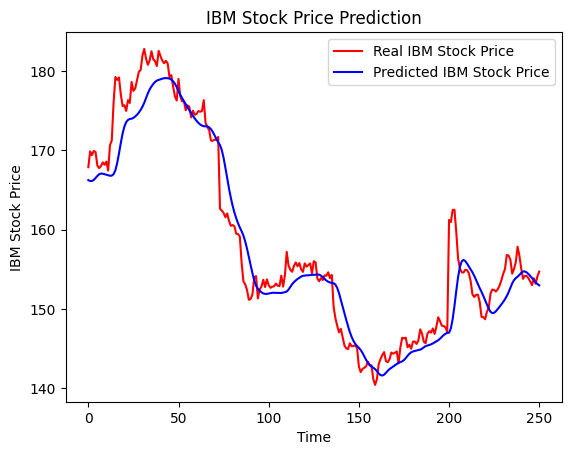

In [15]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [16]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.3319214688876846.
